# ST1504 Deep Learning CA1 Part C

### RNN, LSTM and GRU models applied to Sentiment Analysis for comparison on efficiency and test accuracy

### Name: Haja Amir Rahman
### Class: DAAA/FT?2B/06
### Admin Number: P2100803

### References: 

- [Using GloVe and Pretrained Embedding layers](https://haochen23.github.io/2020/01/nlp-rnn-sentiment.html#.Y3sIcXZByUk)

In [1]:
import tensorflow as tf

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, SimpleRNN, Activation, Dropout, Conv1D
from tensorflow.keras.layers import Embedding, Flatten, LSTM, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
# https://haochen23.github.io/2020/01/nlp-rnn-sentiment.html#.Y3sIcXZByUk

In [3]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# data = pd.read_csv("https://raw.githubusercontent.com/haochen23/nlp-rnn-lstm-sentiment/master/training.1600000.processed.noemoticon.csv", header=None, encoding='cp437')
# print("The shape of the original dataset is {}".format(data.shape))
# data

raw = pd.read_csv('data/Reddit_Data.csv')
raw

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1
...,...,...
37244,jesus,0
37245,kya bhai pure saal chutiya banaya modi aur jab...,1
37246,downvote karna tha par upvote hogaya,0
37247,haha nice,1


In [4]:
raw['category'].value_counts()

 1    15830
 0    13142
-1     8277
Name: category, dtype: int64

In [5]:
NUM = 8277

positive = raw[raw['category']==1].sample(8277)
neutral = raw[raw['category']==0].sample(8277)
negative = raw[raw['category']==-1].sample(8277)

data = pd.concat([positive, neutral, negative], axis=0).sample(frac=1)
# positive.shape, neutral.shape, negative.shape

data

,clean_comment,category
5779,couldn agree more with the author media not tr...,-1
23336,question here why constraintlayout much force...,-1
1341,the elephant the room that more than likely no...,-1
34174,didn answer important questions top netas,1
26542,just because you can read president doesn mean...,-1
...,...,...
22784,dėl būsto norint kažkiek sutaupyti patariu žiū...,0
26934,can the fans start milk abhishekam already the...,0
31300,not banned yet source cousin mine lives rajkot,0
34278,wonder was crying itna paisa khilaake bechara...,-1


In [6]:
def load_glove_model(glove_file, encoding='iso-8859-1'):
    print("[INFO]Loading GloVe Model...")
    model = {}
    with open(glove_file, 'r', encoding=encoding) as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            embeddings = [float(val) for val in split_line[1:]]
            model[word] = embeddings
    print("[INFO] Done...{} words loaded!".format(len(model)))
    return model
# adopted from utils.py
nlp = spacy.blank("en")

def remove_stopwords(sentence):
    '''
    function to remove stopwords
        input: sentence - string of sentence
    '''
    new = []
    # tokenize sentence
    sentence = nlp(sentence)
    for tk in sentence:
        if (tk.is_stop == False) & (tk.pos_ !="PUNCT"):
            new.append(tk.string.strip())
    # convert back to sentence string
    c = " ".join(str(x) for x in new)
    return c


def lemmatize(sentence):
    '''
    function to do lemmatization
        input: sentence - string of sentence
    '''
    sentence = nlp(sentence)
    s = ""
    for w in sentence:
        s +=" "+w.lemma_
    return nlp(s)

def sent_vectorizer(sent, model):
    '''
    sentence vectorizer using the pretrained glove model
    '''
    sent_vector = np.zeros(200)
    num_w = 0
    for w in sent.split():
        try:
            # add up all token vectors to a sent_vector
            sent_vector = np.add(sent_vector, model[str(w)])
            num_w += 1
        except:
            pass
    return sent_vector

In [7]:
data_X = data['clean_comment'].to_numpy().astype('str')
data_y = data['category']
data_y = pd.get_dummies(data_y).to_numpy()

data_X.shape, data_y.shape

((24831,), (24831, 3))

In [8]:
# load the glove model
glove_model = load_glove_model("glove.twitter.27B.200d.txt", encoding='utf-8')
# number of vocab to keep
max_vocab = 18000
# length of sequence that will generate
max_len = 15

tokenizer = Tokenizer(num_words=max_vocab)

[INFO]Loading GloVe Model...
[INFO] Done...1193514 words loaded!


In [9]:
tokenizer.fit_on_texts(data_X)
sequences = tokenizer.texts_to_sequences(data_X)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data_keras = pad_sequences(sequences, maxlen=max_len, padding="post")

data_keras.shape

Found 44226 unique tokens.


(24831, 15)

In [10]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data_keras, data_y, test_size = 0.3, random_state=42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((17381, 15), (7450, 15), (17381, 3), (7450, 3))

In [11]:
# calculate number of words
nb_words = len(tokenizer.word_index) + 1
print(f"Number of words: {nb_words}")

# obtain the word embedding matrix
embedding_matrix = np.zeros((nb_words, 200))

for word, i in word_index.items():
    embedding_vector = glove_model.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Number of words: 44227
Null word embeddings: 13266


In [12]:
# adopted from sent_tran_eval.py
def build_model(nb_words, rnn_model="SimpleRNN", embedding_matrix=None):
    '''
    build_model function:
    inputs: 
        rnn_model - which type of RNN layer to use, choose in (SimpleRNN, LSTM, GRU)
        embedding_matrix - whether to use pretrained embeddings or not
    '''
    model = Sequential()
    # add an embedding layer
    if embedding_matrix is not None:
        model.add(Embedding(nb_words, 
                        200, 
                        weights=[embedding_matrix], 
                        input_length= max_len,
                        trainable = False))
    else:
        model.add(Embedding(nb_words, 
                        200, 
                        input_length= max_len,
                        trainable = False))
        
    # add an RNN layer according to rnn_model
    if rnn_model == "SimpleRNN":
        model.add(SimpleRNN(256))
    elif rnn_model == "LSTM":
        model.add(LSTM(256))
    else:
        model.add(GRU(256))
        
    model.add(Dense(512,activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', 
                optimizer='adam',
                metrics=['accuracy'])
    return model

In [14]:
model_rnn = build_model(nb_words, "SimpleRNN", embedding_matrix)
checkpoint = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/model_rnn.hdf5',verbose=True)
getAcc = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/model_rnnAcc.hdf5',verbose=True,save_best_only=True,monitor='val_accuracy')
getLoss = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/model_rnnLoss.hdf5',verbose=True,save_best_only=True,monitor='val_loss')
model_rnn_history = model_rnn.fit(x_train, y_train, 
                                                epochs=10, 
                                                validation_data=(x_test, y_test), 
                                                callbacks=[checkpoint,getAcc,getLoss, 
                                                EarlyStopping(monitor='val_accuracy', mode='max',patience=5)])
predictions = model_rnn.predict(x_test)
predictions = predictions.argmax(axis=1)
print(classification_report(y_test.argmax(axis=1), predictions))


Epoch 1/10
543/544 [============================>.] - ETA: 0s - loss: 0.8973 - accuracy: 0.5667
Epoch 1: saving model to tmp/checkpoint\model_rnn.hdf5

Epoch 1: val_accuracy improved from -inf to 0.61799, saving model to tmp/checkpoint\model_rnnAcc.hdf5

Epoch 1: val_loss improved from inf to 0.85274, saving model to tmp/checkpoint\model_rnnLoss.hdf5
544/544 [==============================] - 28s 49ms/step - loss: 0.8974 - accuracy: 0.5667 - val_loss: 0.8527 - val_accuracy: 0.6180
Epoch 2/10
544/544 [==============================] - ETA: 0s - loss: 0.8197 - accuracy: 0.6275
Epoch 2: saving model to tmp/checkpoint\model_rnn.hdf5

Epoch 2: val_accuracy improved from 0.61799 to 0.64295, saving model to tmp/checkpoint\model_rnnAcc.hdf5

Epoch 2: val_loss improved from 0.85274 to 0.80901, saving model to tmp/checkpoint\model_rnnLoss.hdf5
544/544 [==============================] - 26s 48ms/step - loss: 0.8197 - accuracy: 0.6275 - val_loss: 0.8090 - val_accuracy: 0.6430
Epoch 3/10
544/544 [=

In [16]:
# evaluating baseline coarse model
print(model_rnn.evaluate(x_test, y_test))
model_rnn.load_weights('tmp/checkpoint/model_rnnAcc.hdf5')
scoreAcc = model_rnn.evaluate(x_test, y_test)
model_rnn.load_weights('tmp/checkpoint/model_rnnLoss.hdf5')
scoreLoss = model_rnn.evaluate(x_test, y_test)
print('Best Acc Test Loss:', scoreAcc[0])
print('Best Acc Test Accuracy:', round(scoreAcc[1],4)*100,'%')
print('Best Loss Test Loss:', scoreLoss[0])
print('Best Loss Test Accuracy:', round(scoreLoss[1],4)*100,'%')

233/233 [==============================] - 3s 12ms/step - loss: 0.9257 - accuracy: 0.6532
[0.9257416725158691, 0.6531543731689453]
233/233 [==============================] - 2s 10ms/step - loss: 0.7775 - accuracy: 0.6600
Best Acc Test Loss: 0.8157018423080444
Best Acc Test Accuracy: 66.47999999999999 %
Best Loss Test Loss: 0.7774913907051086
Best Loss Test Accuracy: 66.0 %


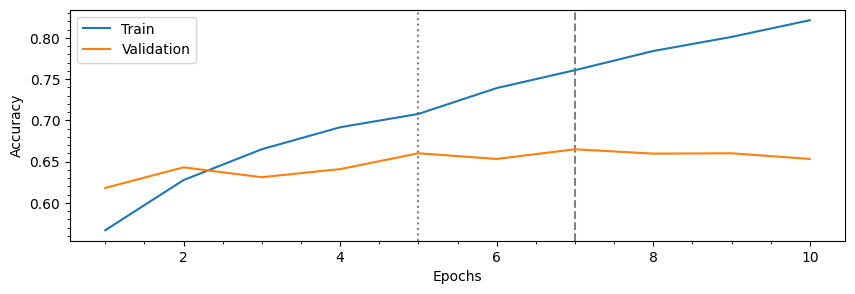

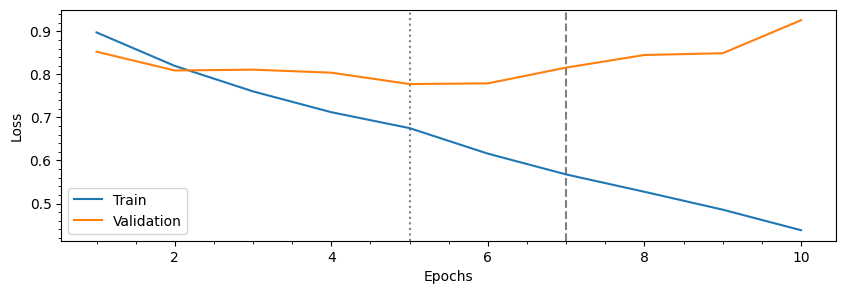

In [17]:
max_val_acc_epoch = np.argmax(list(model_rnn_history.history['val_accuracy']))+1
max_val_loss_epoch = np.argmin(list(model_rnn_history.history['val_loss']))+1
epochs = range(1, len(model_rnn_history.history['accuracy']) + 1)
plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,model_rnn_history.history['accuracy'], label='Train')
plt.plot(epochs,model_rnn_history.history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,model_rnn_history.history['loss'], label='Train')
plt.plot(epochs,model_rnn_history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
# import visualkeras
# from PIL import ImageFont
# visualkeras.layered_view(model_rnn, legend=True)

In [ ]:
# model_rnn.save_weights("./models/rnn-model.h5")

In [20]:
model_lstm = build_model(nb_words, "LSTM", embedding_matrix)
checkpoint = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/model_lstm.hdf5',verbose=True)
getAcc = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/model_lstmAcc.hdf5',verbose=True,save_best_only=True,monitor='val_accuracy')
getLoss = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/model_lstmLoss.hdf5',verbose=True,save_best_only=True,monitor='val_loss')
model_lstm_history = model_lstm.fit(x_train, y_train, 
                                                epochs=10, 
                                                validation_data=(x_test, y_test), 
                                                callbacks=[checkpoint,getAcc,getLoss, 
                                                EarlyStopping(monitor='val_accuracy', mode='max',patience=5)])

predictions = model_lstm.predict(x_test)
predictions = predictions.argmax(axis=1)
print(classification_report(y_test.argmax(axis=1), predictions))


Epoch 1/10
541/544 [============================>.] - ETA: 0s - loss: 0.8018 - accuracy: 0.6285
Epoch 1: saving model to tmp/checkpoint\model_lstm.hdf5

Epoch 1: val_accuracy improved from -inf to 0.68537, saving model to tmp/checkpoint\model_lstmAcc.hdf5

Epoch 1: val_loss improved from inf to 0.70734, saving model to tmp/checkpoint\model_lstmLoss.hdf5
544/544 [==============================] - 16s 24ms/step - loss: 0.8018 - accuracy: 0.6282 - val_loss: 0.7073 - val_accuracy: 0.6854
Epoch 2/10
540/544 [============================>.] - ETA: 0s - loss: 0.6469 - accuracy: 0.7163
Epoch 2: saving model to tmp/checkpoint\model_lstm.hdf5

Epoch 2: val_accuracy improved from 0.68537 to 0.71047, saving model to tmp/checkpoint\model_lstmAcc.hdf5

Epoch 2: val_loss improved from 0.70734 to 0.64752, saving model to tmp/checkpoint\model_lstmLoss.hdf5
544/544 [==============================] - 12s 22ms/step - loss: 0.6471 - accuracy: 0.7162 - val_loss: 0.6475 - val_accuracy: 0.7105
Epoch 3/10
543/

In [21]:
# evaluating baseline coarse model
print(model_lstm.evaluate(x_test, y_test))
model_lstm.load_weights('tmp/checkpoint/model_lstmAcc.hdf5')
scoreAcc = model_lstm.evaluate(x_test, y_test)
model_lstm.load_weights('tmp/checkpoint/model_lstmLoss.hdf5')
scoreLoss = model_lstm.evaluate(x_test, y_test)
print('Best Acc Test Loss:', scoreAcc[0])
print('Best Acc Test Accuracy:', round(scoreAcc[1],4)*100,'%')
print('Best Loss Test Loss:', scoreLoss[0])
print('Best Loss Test Accuracy:', round(scoreLoss[1],4)*100,'%')

233/233 [==============================] - 4s 16ms/step - loss: 1.3009 - accuracy: 0.7569
[1.3008716106414795, 0.7569127678871155]
233/233 [==============================] - 2s 10ms/step - loss: 0.5842 - accuracy: 0.7448
Best Acc Test Loss: 0.6937697529792786
Best Acc Test Accuracy: 75.73 %
Best Loss Test Loss: 0.5841642618179321
Best Loss Test Accuracy: 74.48 %


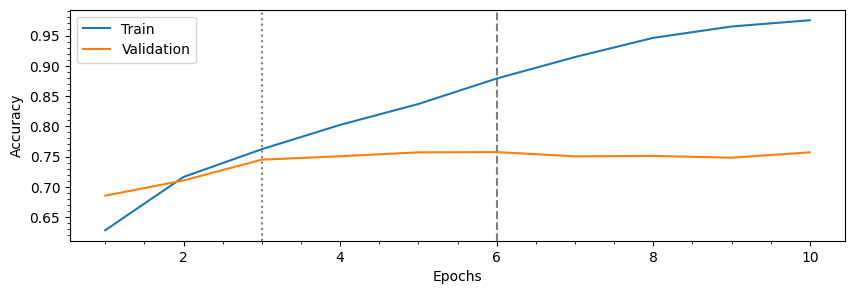

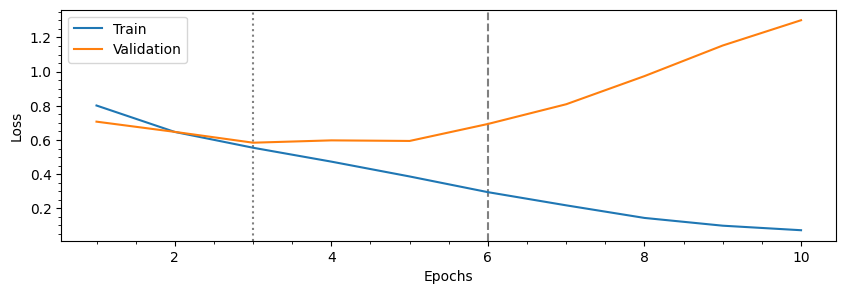

In [22]:
max_val_acc_epoch = np.argmax(list(model_lstm_history.history['val_accuracy']))+1
max_val_loss_epoch = np.argmin(list(model_lstm_history.history['val_loss']))+1
epochs = range(1, len(model_lstm_history.history['accuracy']) + 1)
plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,model_lstm_history.history['accuracy'], label='Train')
plt.plot(epochs,model_lstm_history.history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,model_lstm_history.history['loss'], label='Train')
plt.plot(epochs,model_lstm_history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
# import visualkeras
# from PIL import ImageFont
# visualkeras.layered_view(model_lstm, legend=True)

In [24]:
# model_lstm.save_weights("models/model-lstm.h5")

In [25]:
model_gru = build_model(nb_words, "GRU", embedding_matrix)
checkpoint = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/model_gru.hdf5',verbose=True)
getAcc = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/model_gruAcc.hdf5',verbose=True,save_best_only=True,monitor='val_accuracy')
getLoss = tf.keras.callbacks.ModelCheckpoint('tmp/checkpoint/model_gruLoss.hdf5',verbose=True,save_best_only=True,monitor='val_loss')
model_gru_history = model_gru.fit(x_train, y_train, 
                                                epochs=10, 
                                                validation_data=(x_test, y_test), 
                                                callbacks=[checkpoint,getAcc,getLoss, 
                                                EarlyStopping(monitor='val_accuracy', mode='max',patience=5)])

predictions = model_gru.predict(x_test)
predictions = predictions.argmax(axis=1)
print(classification_report(y_test.argmax(axis=1), predictions))


Epoch 1/10
542/544 [============================>.] - ETA: 0s - loss: 0.8030 - accuracy: 0.6222
Epoch 1: saving model to tmp/checkpoint\model_gru.hdf5

Epoch 1: val_accuracy improved from -inf to 0.69221, saving model to tmp/checkpoint\model_gruAcc.hdf5

Epoch 1: val_loss improved from inf to 0.67669, saving model to tmp/checkpoint\model_gruLoss.hdf5
544/544 [==============================] - 11s 17ms/step - loss: 0.8025 - accuracy: 0.6225 - val_loss: 0.6767 - val_accuracy: 0.6922
Epoch 2/10
544/544 [==============================] - ETA: 0s - loss: 0.6042 - accuracy: 0.7397
Epoch 2: saving model to tmp/checkpoint\model_gru.hdf5

Epoch 2: val_accuracy improved from 0.69221 to 0.73946, saving model to tmp/checkpoint\model_gruAcc.hdf5

Epoch 2: val_loss improved from 0.67669 to 0.63113, saving model to tmp/checkpoint\model_gruLoss.hdf5
544/544 [==============================] - 13s 24ms/step - loss: 0.6042 - accuracy: 0.7397 - val_loss: 0.6311 - val_accuracy: 0.7395
Epoch 3/10
544/544 [=

In [26]:
# evaluating baseline coarse model
print(model_gru.evaluate(x_test, y_test))
model_gru.load_weights('tmp/checkpoint/model_gruAcc.hdf5')
scoreAcc = model_gru.evaluate(x_test, y_test)
model_gru.load_weights('tmp/checkpoint/model_gruLoss.hdf5')
scoreLoss = model_gru.evaluate(x_test, y_test)
print('Best Acc Test Loss:', scoreAcc[0])
print('Best Acc Test Accuracy:', round(scoreAcc[1],4)*100,'%')
print('Best Loss Test Loss:', scoreLoss[0])
print('Best Loss Test Accuracy:', round(scoreLoss[1],4)*100,'%')

233/233 [==============================] - 3s 15ms/step - loss: 1.3427 - accuracy: 0.7591
[1.3427094221115112, 0.7590603828430176]
233/233 [==============================] - 4s 18ms/step - loss: 0.5740 - accuracy: 0.7678
Best Acc Test Loss: 0.5740326046943665
Best Acc Test Accuracy: 76.78 %
Best Loss Test Loss: 0.5740326046943665
Best Loss Test Accuracy: 76.78 %


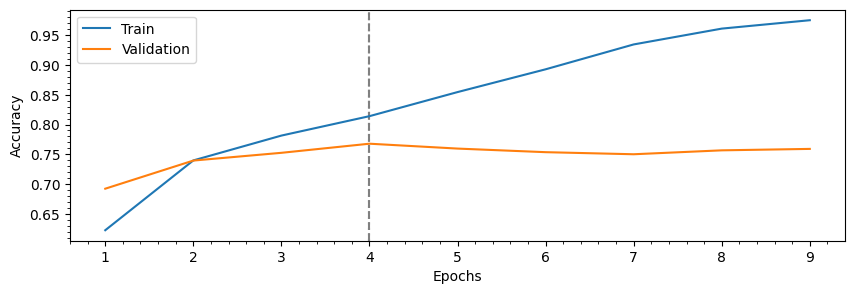

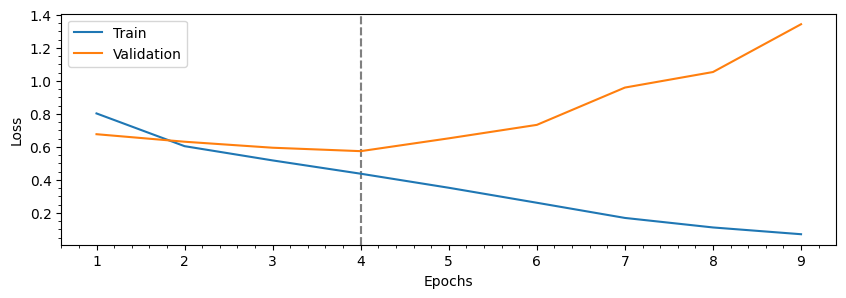

In [27]:
max_val_acc_epoch = np.argmax(list(model_gru_history.history['val_accuracy']))+1
max_val_loss_epoch = np.argmin(list(model_gru_history.history['val_loss']))+1
epochs = range(1, len(model_gru_history.history['accuracy']) + 1)
plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,model_gru_history.history['accuracy'], label='Train')
plt.plot(epochs,model_gru_history.history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.minorticks_on()
plt.axvline(x=max_val_acc_epoch, color='0.5', linestyle='--')
plt.axvline(x=max_val_loss_epoch, color='0.5', linestyle=':')
plt.plot(epochs,model_gru_history.history['loss'], label='Train')
plt.plot(epochs,model_gru_history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
# import visualkeras
# from PIL import ImageFont
# visualkeras.layered_view(model_gru, legend=True)

In [29]:
# model_gru.save_weights("models/model-gru.h5")

### Using a non deeplearning model (TFIDF vectorization) and other traditional machine learning models

In [30]:
data

,clean_comment,category
5779,couldn agree more with the author media not tr...,-1
23336,question here why constraintlayout much force...,-1
1341,the elephant the room that more than likely no...,-1
34174,didn answer important questions top netas,1
26542,just because you can read president doesn mean...,-1
...,...,...
22784,dėl būsto norint kažkiek sutaupyti patariu žiū...,0
26934,can the fans start milk abhishekam already the...,0
31300,not banned yet source cousin mine lives rajkot,0
34278,wonder was crying itna paisa khilaake bechara...,-1


In [31]:
from sklearn.model_selection import train_test_split

x = data['clean_comment'].astype('str')
y = data['category']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
x_train_vec = vectorizer.fit_transform(x_train)
x_test_vec = vectorizer.transform(x_test)

x_train_vec.shape, x_test_vec.shape 

((19864, 10000), (4967, 10000))

## RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier()
model_rf.fit(x_train_vec, y_train)
model_rf.score(x_test_vec, y_test)

predictions = model_rf.predict(x_test_vec)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

          -1       0.75      0.68      0.72      1674
           0       0.77      0.90      0.83      1605
           1       0.79      0.73      0.76      1688

    accuracy                           0.77      4967
   macro avg       0.77      0.77      0.77      4967
weighted avg       0.77      0.77      0.77      4967



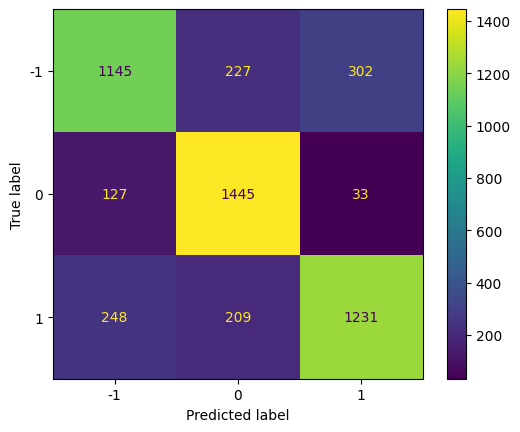

In [ ]:
cm = confusion_matrix(y_test, predictions, labels=model_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_rf.classes_)
disp.plot()


## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

model_lr = LogisticRegression()
model_lr.fit(x_train_vec, y_train)
model_lr.score(x_test_vec, y_test)

predictions = model_lr.predict(x_test_vec)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

          -1       0.85      0.81      0.83      1674
           0       0.82      0.93      0.87      1605
           1       0.87      0.80      0.83      1688

    accuracy                           0.84      4967
   macro avg       0.85      0.85      0.84      4967
weighted avg       0.85      0.84      0.84      4967



c:\Users\amir_\anaconda3\envs\deeplearning_env\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


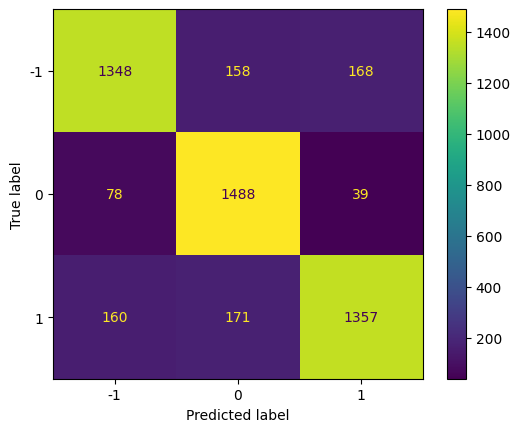

In [ ]:
cm = confusion_matrix(y_test, predictions, labels=model_lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_lr.classes_)
disp.plot()
